In [8]:
import sys
sys.path.append(r"C:\Users\shailaja.akella\Dropbox (Personal)\variability_phase4\state_dependent_variability_paper\figure_codes")

import seaborn as sns
import pandas as pd
import numpy as np
import math
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import statsmodels.api as sm
from statsmodels.formula.api import ols
from IPython.display import display, Markdown

In [9]:
Fs_spikes = 1250

probes = ['probeC', 'probeD', 'probeF', 'probeE', 'probeB', 'probeA']
names = ['V1', 'LM','RL', 'AL','PM', 'AM']
probe_colors = np.array([[0.34648212, 0.54925029, 0.7527105 ],
                         [0.64098424, 0.82729719, 0.90080738],
                         [0.66180315, 0.71585928, 0.911188  ], 
                         [0.91530181, 0.91530181, 0.61530181],
                         [0.98731257, 0.6473664 , 0.36424452],
                         [0.8899654 , 0.28673587, 0.19815456]])

num_states = 3
HS = [-0.5, -0.13, -0.14, 0, 0.12, 0.29]

state_names = ['High frequency', 'Intermediate', 'Low frequency']
short_state_names = [r"$S_{H}$", r"$S_{I}$", r"$S_{L}$"]
state_colors = ['tab:green', 'tab:blue', 'mediumvioletred']
state_cmap = ListedColormap(state_colors, name='states')


sessions = [767871931, 771990200, 778240327, 778998620, 786091066,
            794812542, 831882777, 839068429, 847657808, 840012044,
            766640955, 768515987, 771160300, 774875821, 779839471,
            781842082, 787025148, 789848216, 793224716, 816200189,
            819186360, 819701982, 821695405, 829720705, 835479236]

In [10]:
filepath = '../../figure_codes'

-------------------------------------
Two-way ANOVA for states and areas: 


,sum_sq,df,F,PR(>F)
C(HS),1.122336e+05,5.0,78.768741,3.295479e-82
C(state),2.457723e+05,2.0,431.224888,1.497225e-184
C(HS):C(state),9.431667e+03,10.0,3.309705,2.641966e-04
Residual,6.499880e+06,22809.0,NaN,NaN


-------------------------------------
Pairwise T-test for states: 


$S_{H}$, $S_{I}$: 3.21e-07

$S_{H}$, $S_{L}$: 4.32e-147

$S_{I}$, $S_{L}$: 4.10e-96

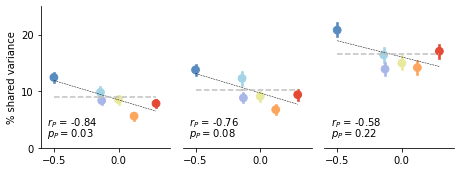

In [22]:
shared_var = np.load(filepath + "/data/variability/shared_variance_sample_size_controlled.npy")

df = pd.DataFrame()
for p_no, probe in enumerate(probes):
    for s_no in range(num_states):
        vals = shared_var[:, p_no, :, s_no]
        temp_df = pd.DataFrame()
        temp_df['% shared variance'] = vals[~np.isnan(vals)]
        temp_df['state'] = short_state_names[s_no]
        temp_df['area'] = names[p_no]
        temp_df['HS'] = HS[p_no]
        df = df.append(temp_df)

fig, ax = plt.subplots(1, 3, figsize = (6.5, 2.5))
for ns in range(num_states):
    sns.regplot(x = 'HS', y = '% shared variance', data = df[df['state'] == short_state_names[ns]],
                   ax = ax[ns], scatter = True, x_estimator = np.mean, ci = 0, x_ci = 95, 
                scatter_kws = {'c':probe_colors, 'color': None, 's': 60}, 
                line_kws = {'color':'k', 'ls': '--', 'lw': 0.5})

    for i, line in enumerate(ax[ns].get_lines()[:-1]):
        line.set_color(probe_colors[i])
    
    mean_val = np.nanmean(df[df['state'] == short_state_names[ns]]['% shared variance'].values)
    ax[ns].plot(HS, np.ones(6)*mean_val, ls = '--' , color = 'silver')
    plt.legend([],[], frameon=False)
    ax[ns].spines['top'].set_visible(False)
    ax[ns].spines['right'].set_visible(False)
    ax[ns].spines['bottom'].set_visible(True)
    ax[ns].spines['left'].set_visible(False)
    ax[ns].set_ylabel('')
    ax[ns].set_xlabel('')
    ax[ns].set_xticks([-0.5, 0])
    ax[ns].set_xlim(-0.6, 0.4)
    ax[ns].set_yticks([])
    
    ax[ns].set_ylim(0, 25)
ax[0].spines['left'].set_visible(True)
ax[0].set_yticks([0, 10, 20], fontsize = 12) 
ax[0].set_ylabel('% shared variance')

# correlation with anatomical hierarchy score - with RL 
for s_no in range(num_states):
    vals = [np.nanmean(df[(df['state'] == short_state_names[s_no]) & (df['area'] == name)]['% shared variance'].values) for name in names]
    res = stats.pearsonr(vals, HS)
    ax[s_no].text(-0.55, 4, r"$r_P$ = " + str(np.round(res[0], 2)))
    ax[s_no].text(-0.55, 2, r"$p_P = $" + str(np.round(res[1], 2)))
plt.tight_layout()

# two way ANOVA
print('-------------------------------------')
print('Two-way ANOVA for states and areas: ')
df = df.rename(columns={"% shared variance": "SV"})
model = ols('SV ~ C(HS) + C(state) + C(HS):C(state)', data=df).fit()
display(sm.stats.anova_lm(model, typ=2)) # F-test 


# comparison across states - check p-vals
print('-------------------------------------')
print('Pairwise T-test for states: ')
p = np.ones((num_states,num_states))
for s1 in range(num_states): 
    for s2 in range(s1 + 1, num_states): 
        x = shared_var[:, :, :, s1].reshape(-1)
        y = shared_var[:, :, :, s2].reshape(-1)
        F, p[s1, s2] = stats.f_oneway(x[~np.isnan(x)], y[~np.isnan(y)]) 
        p_sci = "{:.2e}".format(p[s1, s2])
        display(Markdown(f"{short_state_names[s1]}, {short_state_names[s2]}: {p_sci}"))
        
# plt.savefig('shared_variance.pdf') 
# plt.savefig('shared_variance.png', dpi = 300) 

-------------------------------------
Two-way ANOVA for states and areas: 


,sum_sq,df,F,PR(>F)
C(HS),61.661418,5.0,88.105880,4.451416e-92
C(state),11.914088,2.0,42.559078,3.562893e-19
C(HS):C(state),4.467175,10.0,3.191496,4.164182e-04
Residual,3140.113343,22434.0,NaN,NaN


-------------------------------------
Pairwise T-test for states: 


$S_{H}$, $S_{I}$: 3.42e-18

$S_{H}$, $S_{L}$: 6.65e-02

$S_{I}$, $S_{L}$: 6.82e-12

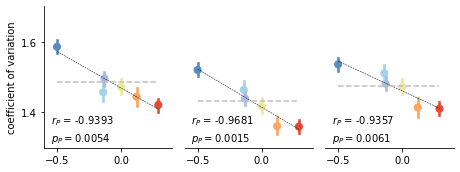

In [23]:
cv = np.load(filepath + "/data/variability/CV_rate_duration_controlled.npy")
                     
df = pd.DataFrame()
for p_no, probe in enumerate(probes):
    for s_no in range(num_states):
        temp_df = pd.DataFrame()
        x = cv[:, p_no, :, s_no]
        temp_df['coefficient of variation'] = x[~np.isnan(x)]
        temp_df['state'] = short_state_names[s_no]
        temp_df['area'] = names[p_no]
        temp_df['HS'] = HS[p_no]
        df = df.append(temp_df)
        
        
fig, ax = plt.subplots(1, 3, figsize = (6.5, 2.5))
for ns in range(num_states):
    sns.regplot(x = 'HS', y = 'coefficient of variation', data = df[df['state'] == short_state_names[ns]],
                   ax = ax[ns], scatter = True, x_estimator = np.mean,  ci = 0, x_ci = 95, 
                scatter_kws = {'c':probe_colors, 'color': None, }, line_kws = {'color':'k', 'ls': '--', 'lw': 0.5})
    
    for i, line in enumerate(ax[ns].get_lines()[:-1]):
        line.set_color(probe_colors[i])
        
    mean_val = np.nanmean(df[df['state'] == short_state_names[ns]]['coefficient of variation'].values)
    ax[ns].plot(HS, np.ones(6)*mean_val, ls = '--' , color = 'silver')
    plt.legend([],[], frameon=False)
    
    ax[ns].spines['top'].set_visible(False)
    ax[ns].spines['right'].set_visible(False)
    ax[ns].spines['bottom'].set_visible(True)
    ax[ns].spines['left'].set_visible(False)
    ax[ns].set_ylabel('')
    ax[ns].set_xlabel('')
    ax[ns].set_xticks([-0.5, 0])
    ax[ns].set_xlim(-0.6, 0.4)
    ax[ns].set_yticks([])
    ax[ns].set_ylim(1.3, 1.7)
ax[0].spines['left'].set_visible(True)
ax[0].set_yticks([1.4, 1.6], fontsize = 12) 
ax[0].set_ylabel('coefficient of variation')
plt.tight_layout()

# correlation with anatomical hierarchy score - with RL
for s_no in range(num_states):
    vals = [np.nanmean(df[(df['state'] == short_state_names[s_no]) & (df['area'] == name)]['coefficient of variation'].values) for name in names]
    res = stats.pearsonr(vals, HS)
    ax[s_no].text(-0.55, 1.37, r"$r_P$ = " + str(np.round(res[0], 4)))
    ax[s_no].text(-0.55, 1.32, r"$p_P = $" + str(np.round(res[1], 4)))  


# Two way ANOVA with states are areas 
print('-------------------------------------')
print('Two-way ANOVA for states and areas: ')
df = df.rename(columns={"coefficient of variation": "CV"})
model = ols('CV ~ C(HS) + C(state) + C(HS):C(state)', data=df).fit()
display(sm.stats.anova_lm(model, typ=2))

# comparison across states - check p-vals
print('-------------------------------------')
print('Pairwise T-test for states: ')
p = np.ones((num_states,num_states))
for s1 in range(num_states): 
    for s2 in range(s1 + 1, num_states): 
        x = cv[:, :, :, s1].reshape(-1)
        y = cv[:, :, :, s2].reshape(-1)
        F, p[s1, s2] = stats.f_oneway(x[~np.isnan(x)], y[~np.isnan(y)]) 
        p_sci = "{:.2e}".format(p[s1, s2])
        display(Markdown(f"{short_state_names[s1]}, {short_state_names[s2]}: {p_sci}"))

# plt.savefig('CV.png', dpi = 300)
# plt.savefig('CV.pdf')

--------------------------------------------------------------
Correlation with anatomical hierarchy score (no RL): 


$S_{H}$: $r_p$ = -0.94, p = 1.78e-02

$S_{I}$: $r_p$ = -0.43, p = 4.70e-01

$S_{L}$: $r_p$ = -0.46, p = 4.38e-01

-------------------------------------
Two-way ANOVA for states and areas: 


,sum_sq,df,F,PR(>F)
C(HS),5.835582,4.0,7.134437,9.927571e-06
C(state),44.037934,2.0,107.679364,7.514886e-47
C(HS):C(state),0.915064,8.0,0.559367,8.118911e-01
Residual,1578.430642,7719.0,NaN,NaN


-------------------------------------
Pairwise T-test for states: 


$S_{H}$, $S_{I}$: 9.54e-05

$S_{H}$, $S_{L}$: 8.14e-34

$S_{I}$, $S_{L}$: 1.20e-32

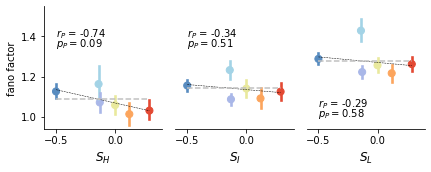

In [24]:
## Fano factor - control 1
ff =np.load(filepath + "/data/variability/FF_RF_rate_controlled.npy")

df = pd.DataFrame()
for p_no, probe in enumerate(probes):
    for s_no in range(num_states):
        temp_df = pd.DataFrame()
        x = ff[:, p_no, :, s_no].reshape(-1)
        temp_df['fano factor'] = x[~np.isnan(x)]
        temp_df['state'] = short_state_names[s_no]
        temp_df['area'] = names[p_no]
        temp_df['HS'] = HS[p_no]
        df = df.append(temp_df)

fig, ax = plt.subplots(1, 3, figsize = (6.1, 2.5))
for ns in range(num_states):
    sns.regplot(x = 'HS', y = 'fano factor', data = df[df['state'] == short_state_names[ns]],
                   ax = ax[ns], scatter = True, x_estimator = np.mean, ci = 0, x_ci = 95, 
                scatter_kws = {'c':probe_colors, 'color': None, }, line_kws = {'color':'k', 'ls': '--', 'lw': 0.5})
    
    for i, line in enumerate(ax[ns].get_lines()[:-1]):
        line.set_color(probe_colors[i])
    
    mean_val = np.nanmean(df[df['state'] == short_state_names[ns]]['fano factor'].values)
    ax[ns].plot(HS, np.ones(6)*mean_val, ls = '--' , color = 'silver')
    plt.legend([],[], frameon=False)
    ax[ns].spines['top'].set_visible(False)
    
    ax[ns].spines['right'].set_visible(False)
    ax[ns].spines['bottom'].set_visible(True)
    ax[ns].spines['left'].set_visible(False)
    ax[ns].set_xlabel(short_state_names[ns], fontsize = 12)
    ax[ns].set_ylabel('')
    ax[ns].set_xticks([-0.5, 0])
    ax[ns].set_xlim(-0.6, 0.4)
    ax[ns].set_yticks([])
    ax[ns].set_ylim(0.94, 1.55)
ax[0].spines['left'].set_visible(True)
ax[0].set_yticks([1.0, 1.2, 1.4], fontsize = 12) 
ax[0].set_ylabel('fano factor')

# correlation with anatomical hierarchy score - with RL
for s_no in range(num_states):
    vals = [np.nanmean(df[(df['state'] == short_state_names[s_no]) & (df['area'] == name)]['fano factor'].values) for name in names]
    res = stats.pearsonr(vals, HS)
    if s_no !=2:
        ax[s_no].text(-0.5, 1.4, r"$r_P$ = " + str(np.round(res[0], 2)))
        ax[s_no].text(-0.5, 1.35, r"$p_P = $" + str(np.round(res[1], 2)))
    else: 
        ax[s_no].text(-0.5, 1.05, r"$r_P$ = " + str(np.round(res[0], 2)))
        ax[s_no].text(-0.5, 1, r"$p_P = $" + str(np.round(res[1], 2)))        
plt.tight_layout()

# correlation with anatomical hierarchy score - without RL
print('--------------------------------------------------------------')
print('Correlation with anatomical hierarchy score (no RL): ')
HS_no_RL= [-0.5, -0.13,  0, 0.12, 0.29]
for s_no in range(num_states):
    vals = [np.nanmean(df[(df['state'] == short_state_names[s_no]) & (df['area'] == name)]['fano factor'].values) for name in names if name!='RL']
    res = stats.pearsonr(vals, HS_no_RL)
    display(Markdown(f"{short_state_names[s_no]}: $r_p$ = {res[0]:.2f}, p = {res[1]:.2e}"))
    
    
# two way ANOVA
print('-------------------------------------')
print('Two-way ANOVA for states and areas: ')
df = df.rename(columns={"fano factor": "FF"})
model = ols('FF ~ C(HS) + C(state) + C(HS):C(state)', data=df[df.area!='RL']).fit()
display(sm.stats.anova_lm(model, typ=2)) # type 1 and type 2

# comparison across states - check p-vals
print('-------------------------------------')
print('Pairwise T-test for states: ')
p = np.ones((num_states,num_states))
for s1 in range(num_states): 
    for s2 in range(s1 + 1, num_states): 
        x = ff[:, :, :, s1].reshape(-1)
        y = ff[:, :, :, s2].reshape(-1)
        F, p[s1, s2] = stats.f_oneway(x[~np.isnan(x)], y[~np.isnan(y)]) 
        p_sci = "{:.2e}".format(p[s1, s2])
        display(Markdown(f"{short_state_names[s1]}, {short_state_names[s2]}: {p_sci}"))
        
# plt.savefig('FF_RF_rate_controlled.png', dpi = 300)
# plt.savefig('FF_RF_rate_controlled.pdf')

C:\Users\shailaja.akella\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
C:\Users\shailaja.akella\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice
C:\Users\shailaja.akella\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


--------------------------------------------------------------
Correlation with anatomical hierarchy score (no RL): 


C:\Users\shailaja.akella\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice


$S_{H}$: $r_p$ = -0.90, p = 3.76e-02

$S_{I}$: $r_p$ = -0.86, p = 6.08e-02

$S_{L}$: $r_p$ = -0.81, p = 9.41e-02

-------------------------------------
Two-way ANOVA for states and areas (no RL): 


,sum_sq,df,F,PR(>F)
C(HS),0.087749,4.0,2.669039,0.032469
C(state),0.051314,2.0,3.121636,0.045535
C(HS):C(state),0.001361,8.0,0.020701,0.999998
Residual,2.441079,297.0,NaN,NaN


-------------------------------------
Pairwise T-test ANOVA for states: 


C:\Users\shailaja.akella\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:73: RuntimeWarning: Mean of empty slice
C:\Users\shailaja.akella\Anaconda3\envs\allensdk\lib\site-packages\ipykernel_launcher.py:74: RuntimeWarning: Mean of empty slice


$S_{H}$, $S_{I}$: 1.02e-02

$S_{H}$, $S_{L}$: 7.32e-10

$S_{I}$, $S_{L}$: 9.28e-04

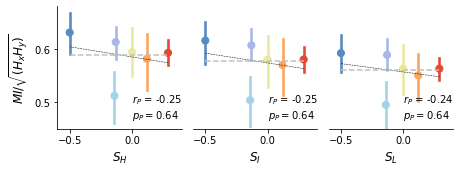

In [7]:
mi = np.load(filepath + "/data/variability/mi.npy")

df = pd.DataFrame()
for p_no, probe in enumerate(probes):
    for s_no in range(num_states):
        vals = np.nanmean(mi[:, p_no,:, s_no], axis = -1) 
        temp_df = pd.DataFrame()
        temp_df['MI'] = vals[~np.isnan(vals)]
        temp_df['state'] = short_state_names[s_no]
        temp_df['area'] = names[p_no]
        temp_df['HS'] = HS[p_no]
        df = df.append(temp_df)


fig, ax = plt.subplots(1, 3, figsize = (6.5, 2.5))
for ns in range(num_states):
    sns.regplot(x = 'HS', y = 'MI', data = df[df['state'] == short_state_names[ns]],
                   ax = ax[ns], scatter = True, x_estimator = np.mean, ci = 0, x_ci = 95, 
                scatter_kws = {'c':probe_colors, 'color': None, }, line_kws = {'color':'k', 'ls': '--', 'lw': 0.5})
    mean_val = np.nanmean(np.nanmean(np.nanmean(mi[:, :, :, ns], axis = -1), axis = -1))
    
    for i, line in enumerate(ax[ns].get_lines()[:-1]):
        line.set_color(probe_colors[i])
    
    ax[ns].plot(HS, np.ones(6)*mean_val, ls = '--' , color = 'silver')
    plt.legend([],[], frameon=False)
    ax[ns].spines['top'].set_visible(False)
    ax[ns].spines['right'].set_visible(False)
    ax[ns].spines['bottom'].set_visible(True)
    ax[ns].spines['left'].set_visible(False)
    ax[ns].set_xlabel(short_state_names[ns], fontsize = 12)
    ax[ns].set_ylabel('')
    ax[ns].set_xticks([-0.5, 0])
    ax[ns].set_xlim(-0.6, 0.4)
    ax[ns].set_yticks([])
    ax[ns].set_ylim(0.45, 0.68)
ax[0].spines['left'].set_visible(True)
ax[0].set_yticks([0.5, 0.6], fontsize = 12) 
ax[0].set_ylabel(r"$MI/\sqrt{(H_{x}H_{y})}$", fontsize = 12)
plt.tight_layout()

# correlation with anatomical hierarchy score - with RL
for s_no in range(num_states):
    vals = [np.nanmean(df[(df['state'] == short_state_names[s_no]) & (df['area'] == name)]['MI'].values) for name in names]
    res = stats.pearsonr(vals, HS)
    ax[s_no].text(0, 0.50, r"$r_P$ = " + str(np.round(res[0], 2)))
    ax[s_no].text(0, 0.47, r"$p_P = $" + str(np.round(res[1], 2)))
plt.tight_layout()


# correlation with anatomical hierarchy score - without RL
print('--------------------------------------------------------------')
print('Correlation with anatomical hierarchy score (no RL): ')
HS_no_RL= [-0.5, -0.13,  0, 0.12, 0.29]
for s_no in range(num_states):
    vals = [np.nanmean(df[(df['state'] == short_state_names[s_no]) & (df['area'] == name)]['MI'].values) for name in names if name!='RL']
    res = stats.pearsonr(vals, HS_no_RL)
    display(Markdown(f"{short_state_names[s_no]}: $r_p$ = {res[0]:.2f}, p = {res[1]:.2e}"))
    
    
# two way ANOVA
print('-------------------------------------')
print('Two-way ANOVA for states and areas (no RL): ')
model = ols('MI ~ C(HS) + C(state) + C(HS):C(state)', data=df[df.area!='RL']).fit()
display(sm.stats.anova_lm(model, typ=2)) # type 1 and type 2

# comparison across states - check p-vals
print('-------------------------------------')
print('Pairwise T-test ANOVA for states: ')
p = np.ones((num_states,num_states))
for s1 in range(num_states): 
    for s2 in range(s1 + 1, num_states): 
        F, p[s1, s2] =  stats.ttest_rel(np.nanmean(np.nanmean(mi[:, :, :, s1], axis = -1), axis = -1), 
                                        np.nanmean(np.nanmean(mi[:, :, :, s2], axis = -1), axis = -1)) 
        p_sci = "{:.2e}".format(p[s1, s2])
        display(Markdown(f"{short_state_names[s1]}, {short_state_names[s2]}: {p_sci}"))
        
# plt.savefig('mi.png', dpi = 300)
# plt.savefig('mi.pdf')

In [18]:
2.16e-03 < 0.001

False